Definition of Normal

$f(y|\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{{(y-\mu)}^2}{2\sigma^2}}$

$\mathcal{L}(\mu,\sigma|y) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{{(y-\mu)}^2}{2\sigma^2}}$

Definition of Negative Binomial

$f(y|n,p) = \frac{\Gamma(y+n)}{\Gamma(y+1)\Gamma(n)} p^n (1-p)^y$

$\mathcal{L}(n,p|y) = \frac{\Gamma(y+n)}{\Gamma(y+1)\Gamma(n)} p^n (1-p)^y$

Definition of Weibull

$f(y|\lambda,k) = \frac{k}{\lambda} (\frac{y}{\lambda})^{k-1} e^{-(y/\lambda)^k}$

$\mathcal{L}(\lambda,k|y) = \frac{k}{\lambda} (\frac{y}{\lambda})^{k-1} e^{-(y/\lambda)^k}$

In [1]:
import sympy as sp
sp.init_printing()

In [2]:
y, m, s, n, p, l, k = sp.symbols('y \mu \sigma n p \lambda k')

In [3]:
display(y)
display(m)
display(s)
display(n)
display(p)
display(l)
display(k)

In [4]:
norm_dist = sp.Mul((1/sp.sqrt(2*sp.pi*(s**2))),sp.exp((-1*((y-m)**2) / (2*(s**2)))),evaluate=False)

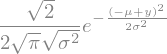

In [5]:
norm_dist

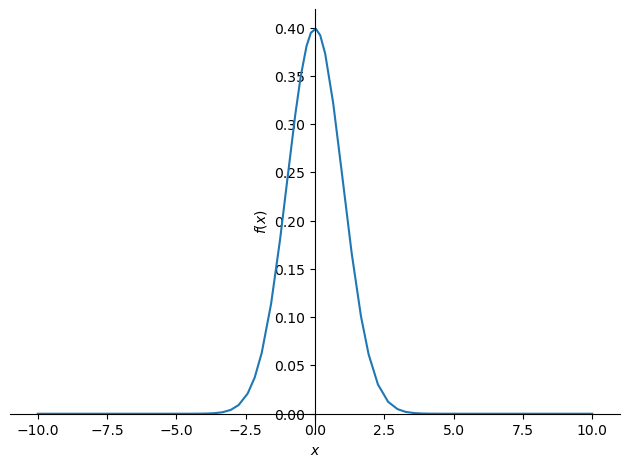

In [6]:
sp.plot(norm_dist.subs({'\mu':0,'\sigma':1,'y':'x'}))

Plot likelihood: these will be...
$\mathcal{L}(\mu|y,\sigma)$
and
$\mathcal{L}(\sigma|y,\mu)$

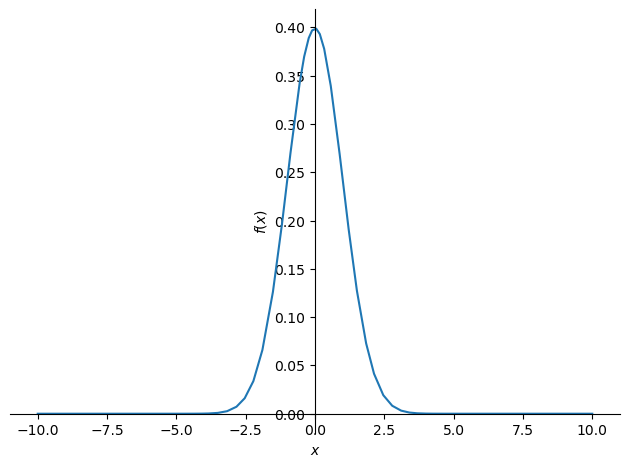

In [7]:
sp.plot(norm_dist.subs({'\mu':'x','\sigma':1,'y':0}))

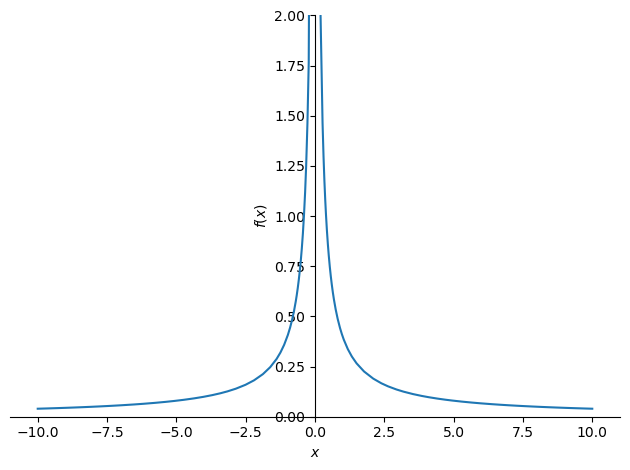

In [8]:
sp.plot(norm_dist.subs({'\mu':0,'\sigma':'x','y':0}),ylim=[0,2])

Plot Negative Log-Likelihood: these will be...
$-\log(\mathcal{L}(\mu|y,\sigma))$
and
$-\log(\mathcal{L}(\sigma|y,\mu))$

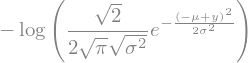

In [9]:
-1*sp.log(norm_dist)

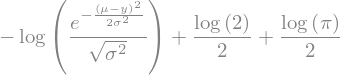

In [10]:
negll_norm_dist = sp.expand_log(sp.simplify(-1*sp.log(norm_dist)),force=False)
negll_norm_dist

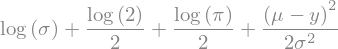

In [11]:
negll_norm_dist = sp.expand_log(sp.simplify(-1*sp.log(norm_dist)),force=True)
negll_norm_dist

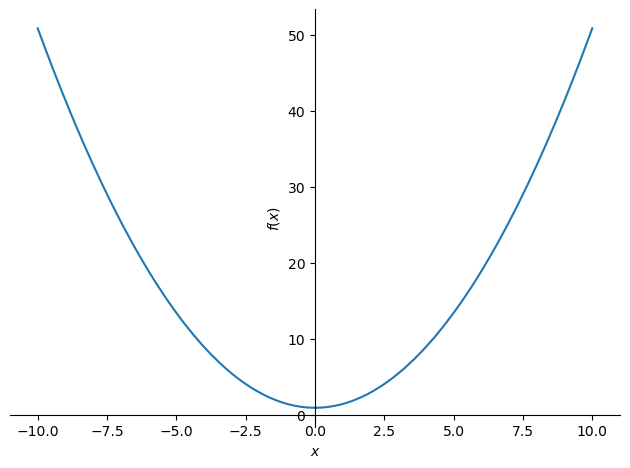

In [12]:
sp.plot(negll_norm_dist.subs({'\mu':'x','\sigma':1,'y':0}))

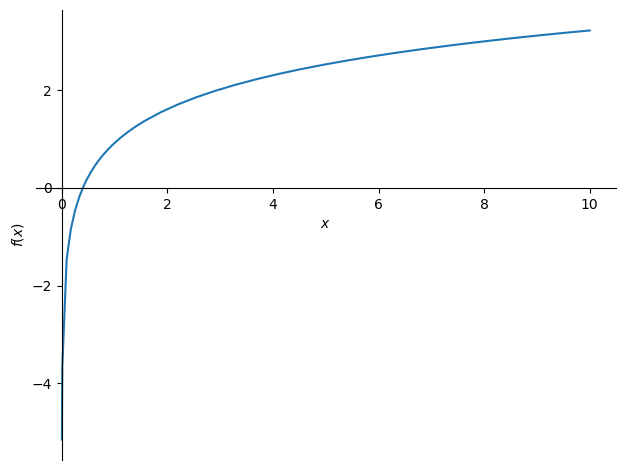

In [13]:
sp.plot(negll_norm_dist.subs({'\mu':0,'\sigma':'x','y':0}))

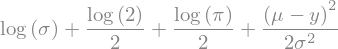

In [14]:
negll_norm_dist

In [15]:
import numpy as np
import math as m
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

2023-11-14 10:04:56.166935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 10:04:57.549604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
def norm_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    l_mu, l_sigma = tf.unstack(y_pred, axis=-1)
    l_mu = tf.expand_dims(l_mu,-1)
    l_sigma = tf.expand_dims(l_sigma,-1)
    
    t1 = tf.math.log(l_sigma)
    t2 = tf.math.log(2.0)/2.0
    t3 = tf.math.log(m.pi)/2.0
    t4 = tf.math.pow(l_mu-y_true,2.0) / (2.0 * tf.math.pow(l_sigma,2.0))

    loss_ = t1+t2+t3+t4
    return tf.squeeze(loss_)

In [ ]:
# Equivalent
def norm_dist_loss_torch(y_pred, y_true):
    y_true = torch.unsqueeze(y_true,axis=-1)
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    l_mu, l_sigma = torch.unbind(y_pred, axis=-1)
    l_mu = torch.unsqueeze(l_mu,-1)
    l_sigma = torch.unsqueeze(l_sigma,-1)
        
    t1 = torch.log(l_sigma)
    t2 = torch.log(torch.Tensor([2.0]))/2.0
    t3 = torch.log(torch.Tensor([torch.pi]))/2.0
    t4 = torch.pow(l_mu-y_true,2.0) / (2.0 * torch.pow(l_sigma,2.0))

    loss_ = t1.to(device)+t2.to(device)+t3.to(device)+t4
    mask = torch.logical_not(torch.eq(y_true, 0)).to(loss_.dtype)
    loss_ *= mask
    
    return torch.squeeze(loss_)

In [17]:
# Make some data
with_mu = 0.0
with_sigma = 3.0
data_size = 1000
theta = np.pi * -0.1
R = np.array([[np.cos(theta),-np.sin(theta)],
              [np.sin(theta),np.cos(theta)]])

# Training
X = np.random.uniform(size=(data_size,1))*100.0
Y = np.random.normal(0.0,with_sigma,size=(data_size,1))
temp = np.matmul(np.hstack([X,Y]),R)
X = temp[:,0:1]
Y = temp[:,1:2]

# Validation
X_val = np.random.uniform(size=(data_size,1))*100.0
Y_val = np.random.normal(0.0,with_sigma,size=(data_size,1))
temp = np.matmul(np.hstack([X_val,Y_val]),R)
X_val = temp[:,0:1]
Y_val = temp[:,1:2]


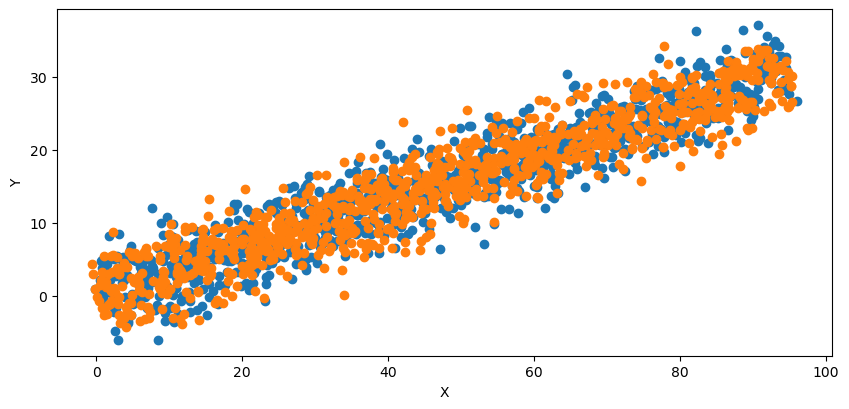

In [18]:
plt.scatter(X[:,0],Y[:,0])
plt.scatter(X_val[:,0],Y_val[:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           40          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1)            21          ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1)            21          ['dense[0][0]']                  
                                                                                              

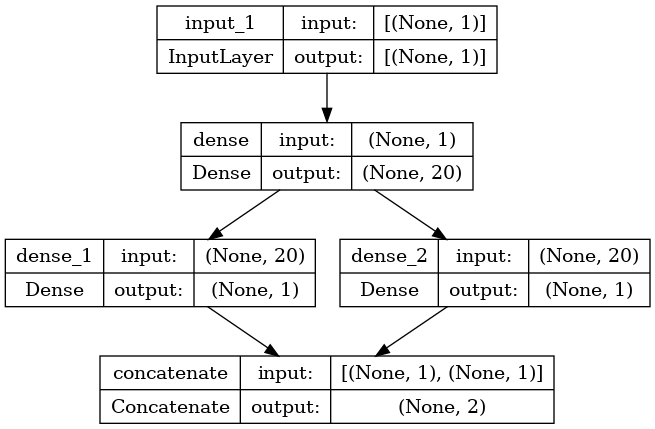

In [19]:
x1 = keras.layers.Input((1,))
y1 = x1

y1 = keras.layers.Dense(20,activation='tanh')(y1)

y2 = keras.layers.Dense(1,activation='linear')(y1)
y3 = keras.layers.Dense(1,activation='softplus')(y1)

y1 = keras.layers.Concatenate(-1)([y2,y3])
    
model = keras.Model(x1,y1)
model.summary()
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [20]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=norm_dist_loss)

In [21]:
model.predict(X)

32/32 [==============================] - 0s 661us/step


array([[ 0.05090851,  0.46646717],
       [ 0.06555021,  0.4665783 ],
       [ 0.08830929,  0.46388906],
       ...,
       [ 0.07827738,  0.36247408],
       [ 0.07703197,  0.46575928],
       [-0.00761193,  0.45563734]], dtype=float32)

In [22]:
model.evaluate(X_val,Y_val)

32/32 [==============================] - 0s 1ms/step - loss: 763.3253


In [23]:
model.predict(X[0:1])

1/1 [==============================] - 0s 23ms/step


array([[0.05090852, 0.46646717]], dtype=float32)

In [24]:
keras.losses.mean_squared_error(Y[0:2],model.predict(X[0:2])[:,0])

1/1 [==============================] - 0s 17ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([142.39447, 322.83038], dtype=float32)>

In [25]:
norm_dist_loss(Y[0:2],model.predict(X[0:2]))

1/1 [==============================] - 0s 16ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([327.76364, 741.0256 ], dtype=float32)>

In [26]:
negll_norm_dist.subs({'y':Y[0,0],
                      '\mu':model.predict(X[0:2])[0,0],
                      '\sigma':model.predict(X[0:2])[0,1]}).evalf()

1/1 [==============================] - 0s 16ms/step


In [27]:
negll_norm_dist.subs({'y':Y[1,0],
                      '\mu':model.predict(X[0:2])[1,0],
                      '\sigma':model.predict(X[0:2])[1,1]}).evalf()

1/1 [==============================] - 0s 16ms/step


In [28]:
model.fit(X,Y,epochs=1,verbose=2)

32/32 - 1s - loss: 312.0872 - 949ms/epoch - 30ms/step


In [29]:
history = model.fit(X,Y,
                    epochs=1000,
                    verbose=0,
                    validation_data=(X_val,Y_val))

In [30]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

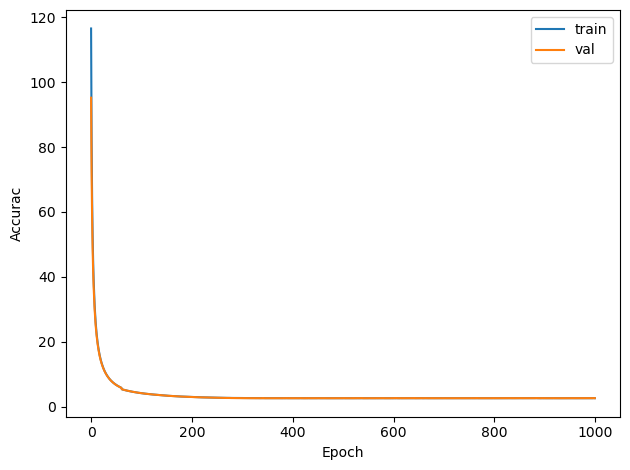

In [31]:
plt.figure(1)  
# summarize history for accuracy 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.ylabel('Accurac')  
plt.xlabel('Epoch')  
plt.tight_layout()
plt.show()  

In [32]:
model.predict(X_val[0:10])

1/1 [==============================] - 0s 18ms/step


array([[ 5.237112 ,  3.3348804],
       [ 4.092877 ,  3.325149 ],
       [12.08994  ,  3.1538236],
       [16.467812 ,  3.1395767],
       [17.773664 ,  3.1400886],
       [14.546896 ,  3.132884 ],
       [ 1.0748045,  3.2320967],
       [15.703484 ,  3.1368377],
       [22.344568 ,  3.0866635],
       [31.084637 ,  2.853022 ]], dtype=float32)

In [33]:
Y_val[0:10]

array([[ 9.10968114],
       [ 0.56570069],
       [ 7.29928193],
       [13.20457521],
       [16.94181514],
       [11.15175431],
       [ 1.47673901],
       [16.61950802],
       [19.60991716],
       [32.65852008]])

In [34]:
X_test = np.expand_dims(np.linspace(0.0,100.0,num=200),-1)
Y_pred = model.predict(X_test)
Y_pred[0:10][:,0]+Y_pred[0:10][:,1]

7/7 [==============================] - 0s 963us/step


array([3.7391014, 4.2907286, 4.43701  , 4.565591 , 4.69372  , 4.8221226,
       4.950853 , 5.079933 , 5.2093897, 5.3392477], dtype=float32)

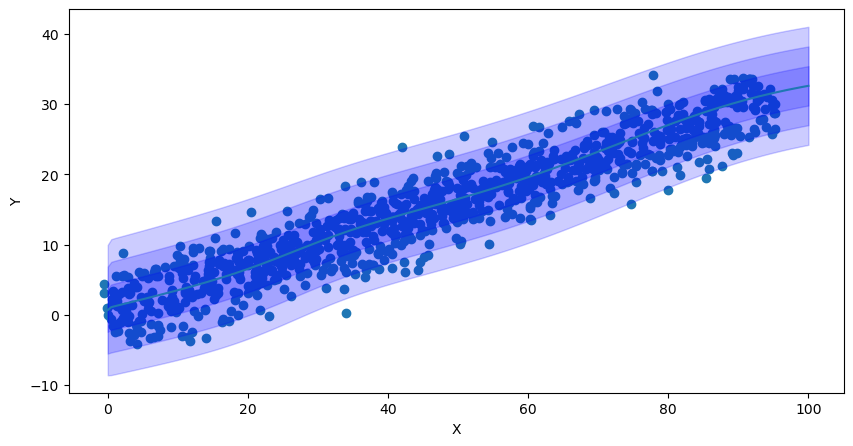

In [35]:
plt.scatter(X_val,Y_val)
plt.plot(X_test[:,0],Y_pred[:,0])
plt.fill_between(X_test[:,0],
                 Y_pred[:,0]-Y_pred[:,1],
                 Y_pred[:,0]+Y_pred[:,1],
                 alpha=0.2,
                 color='blue')
plt.fill_between(X_test[:,0],
                 Y_pred[:,0]-2.0*Y_pred[:,1],
                 Y_pred[:,0]+2.0*Y_pred[:,1],
                 alpha=0.2,
                 color='blue')
plt.fill_between(X_test[:,0],
                 Y_pred[:,0]-3.0*Y_pred[:,1],
                 Y_pred[:,0]+3.0*Y_pred[:,1],
                 alpha=0.2,
                 color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)

In [15]:
# for simplicity
Gamma = sp.functions.special.gamma_functions.gamma

In [16]:
neg_bin_dist = sp.Mul((Gamma(y+n)/(Gamma(y+1)*Gamma(n))),(p**n)*(1-p)**y,evaluate=False)

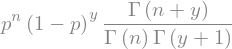

In [17]:
neg_bin_dist

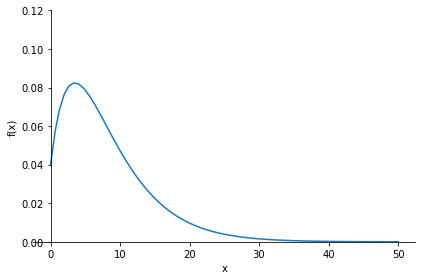

In [18]:
sp.plot(neg_bin_dist.subs({'n':2,'p':0.2,'y':'x'}),('x',0,50),ylim=[0,0.12])

Plot likelihood...

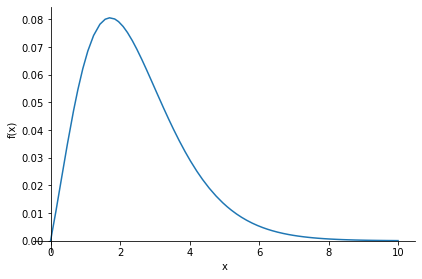

In [19]:
sp.plot(neg_bin_dist.subs({'n':'x','p':0.2,'y':5}),('x',0,10))

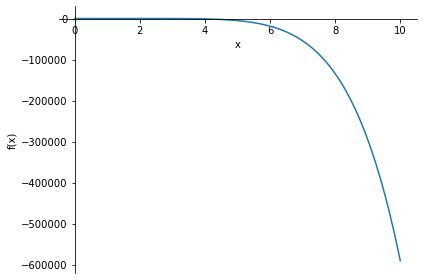

In [20]:
sp.plot(neg_bin_dist.subs({'n':1,'p':'x','y':5}),('x',0,10))

Plot negative log likelihood

In [21]:
negll_neg_bin_dist = sp.expand_log(sp.simplify(sp.Mul(-1*sp.log(neg_bin_dist))),force=True)
negll_neg_bin_dist

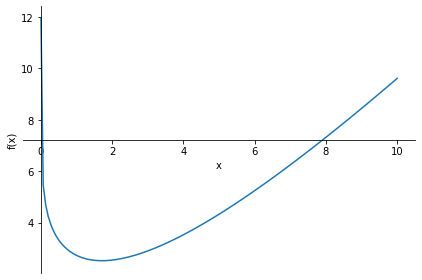

In [22]:
sp.plot(negll_neg_bin_dist.subs({'n':'x','p':0.2,'y':5}),('x',0.0001,10))

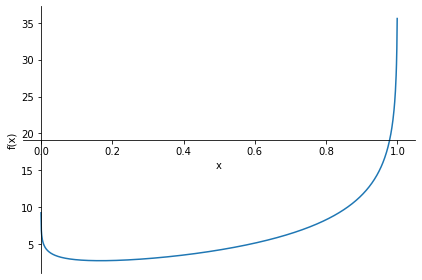

In [23]:
sp.plot(negll_neg_bin_dist.subs({'n':1,'p':'x','y':5}),('x',0.0001,10),nb_of_points=10000,adaptive=False)

In [24]:
negll_neg_bin_dist

### Needs this other TF function
`tf.math.lgamma`

In [57]:
def neg_binom_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: n and p (softplus, softplus)
    l_n, l_p = tf.unstack(y_pred, axis=-1)
    l_n = tf.expand_dims(l_n,-1)
    l_p = tf.expand_dims(l_p,-1)
    
    t1 = -1.0*l_n*tf.math.log(l_p)
    t2 = -1.0*y_true*tf.math.log(1.0-l_p)
    t3 = tf.math.log(tf.math.lgamma(l_n))
    t4 = -1.0*tf.math.log(tf.math.lgamma(l_n+y_true))
    t5 = tf.math.log(tf.math.lgamma(y_true+1.0))

    loss_ = t1+t2+t3+t4+t5
    return tf.squeeze(loss_)

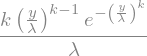

In [5]:
weibull_dist = (k/l)*((y/l)**(k-1))*sp.exp(-1*((y/l)**k))
weibull_dist

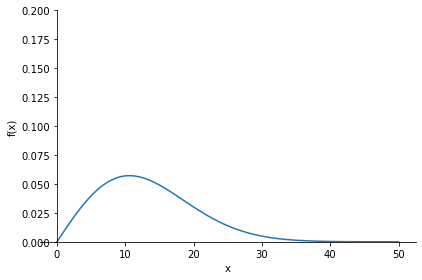

In [6]:
sp.plot(weibull_dist.subs({'k':2,'\lambda':15,'y':'x'}),('x',0,50),ylim=[0,0.2])

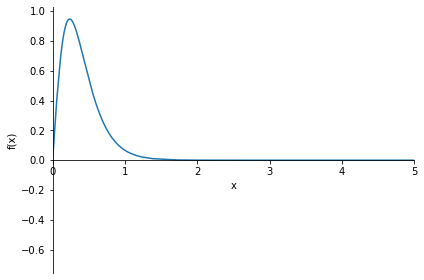

In [7]:
sp.plot(weibull_dist.subs({'k':'x','\lambda':15,'y':0.05}),xlim=[0,5])

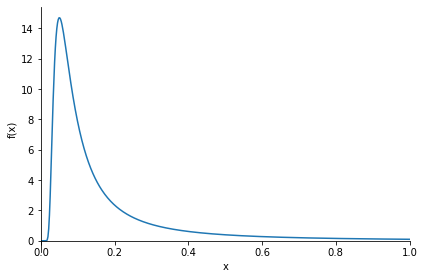

In [8]:
sp.plot(weibull_dist.subs({'k':2,'\lambda':'x','y':0.05}), xlim=[0,1], nb_of_points=10000,adaptive=False)

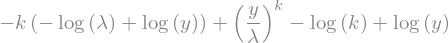

In [9]:
negll_weibull_dist = sp.expand_log(sp.simplify(sp.Mul(-1*sp.log(weibull_dist))),force=True)
negll_weibull_dist

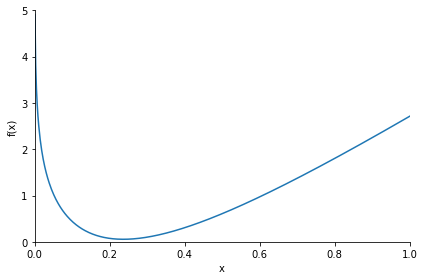

In [37]:
sp.plot(negll_weibull_dist.subs({'k':'x','\lambda':15,'y':0.05}),
        xlim=[0,1],ylim=[0,5],nb_of_points=10000,adaptive=False)

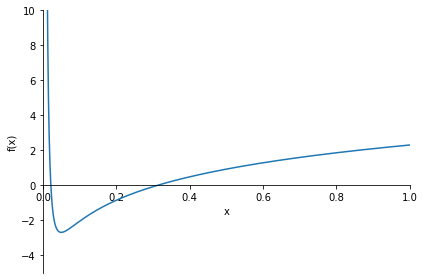

In [43]:
sp.plot(negll_weibull_dist.subs({'k':2,'\lambda':'x','y':0.05}),
        xlim=[0,1], ylim=[-5,10], nb_of_points=10000,adaptive=False)

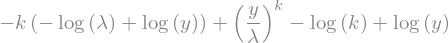

In [56]:
negll_weibull_dist

In [58]:
def weibull_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: k and g(amma) (softplus, softplus)
    l_k, l_g = tf.unstack(y_pred, axis=-1)
    l_k = tf.expand_dims(l_k,-1)
    l_g = tf.expand_dims(l_g,-1)
    
    t1 = -1.0*l_k*(-1.0*tf.math.log(l_g)+tf.math.log(y_true))
    t2 = (y_true / l_g)**l_k
    t3 = -1.0*tf.math.log(l_k)
    t4 = tf.math.log(y_true)

    loss_ = t1+t2+t3+t4
    return tf.squeeze(loss_)